In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('waste_images.zip','r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
os.listdir('waste_images/train')

['paper', 'plastic', 'cardboard', 'metal', 'glass', 'trash']

In [ ]:
for dirpath,dirnames,filenames in os.walk('waste_images'):
  print(f'there are {len(filenames)} images in {len(dirnames)} folder in {dirpath}')

there are 0 images in 2 folder in waste_images
there are 0 images in 6 folder in waste_images/train
there are 474 images in 0 folder in waste_images/train/paper
there are 382 images in 0 folder in waste_images/train/plastic
there are 319 images in 0 folder in waste_images/train/cardboard
there are 325 images in 0 folder in waste_images/train/metal
there are 401 images in 0 folder in waste_images/train/glass
there are 107 images in 0 folder in waste_images/train/trash
there are 0 images in 6 folder in waste_images/test
there are 120 images in 0 folder in waste_images/test/paper
there are 100 images in 0 folder in waste_images/test/plastic
there are 84 images in 0 folder in waste_images/test/cardboard
there are 85 images in 0 folder in waste_images/test/metal
there are 100 images in 0 folder in waste_images/test/glass
there are 30 images in 0 folder in waste_images/test/trash


In [ ]:
print(len(os.listdir('waste_images/train/plastic')))

382


In [ ]:
train_dir='waste_images/train'
test_dir='waste_images/test'

In [ ]:
import tensorflow as tf
BATCH_SIZE=32
IMG_SIZE=(224,224)
train_data=tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE,
                                                       label_mode='int',
                                                       seed=1227,
                                                       shuffle=True)
test_data=tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE,
                                                      label_mode='int',
                                                      seed=1227,
                                                      shuffle=True)

Found 2008 files belonging to 6 classes.
Found 519 files belonging to 6 classes.


In [ ]:
class_names=train_data.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,10))
for images,labels in train_data.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
test_batches=tf.data.experimental.cardinality(test_data)
validation_data=test_data.take(test_batches//5)
test_data=test_data.skip(test_batches//5)

In [ ]:
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_data))

In [ ]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

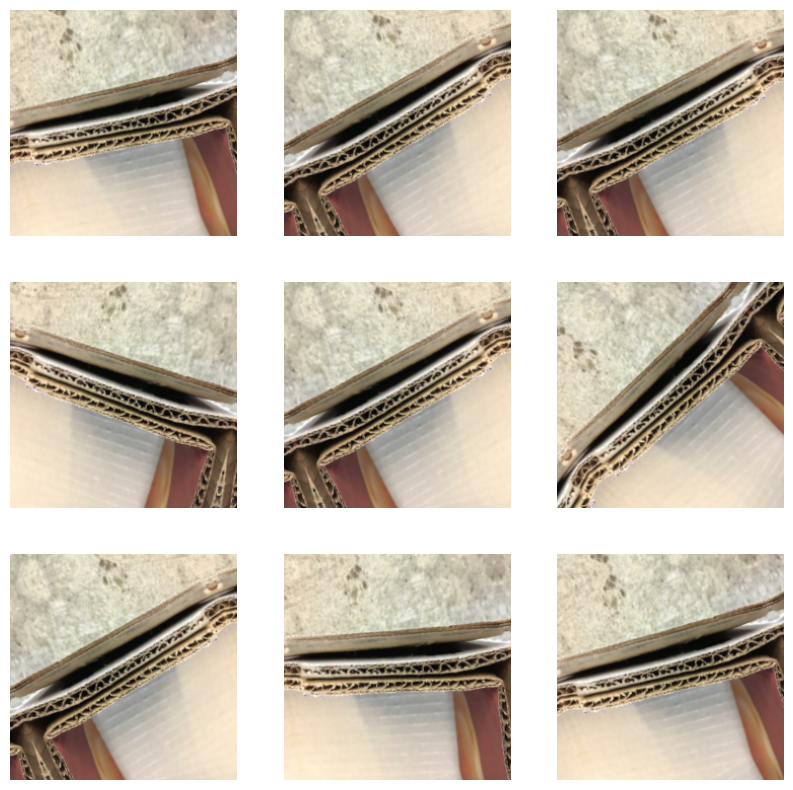

In [ ]:
for image, _ in train_data.take(1):
  plt.figure(figsize=(10,10))
  first_image=image[0]
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    augmented_image=data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

In [ ]:
IMG_SHAPE=IMG_SIZE + (3,)
base_model=tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')

In [ ]:
'''image_batch, label_batch=next(iter(train_data))
feature_batch=base_model(image_batch)
print(feature_batch.shape)'''

'image_batch, label_batch=next(iter(train_data))\nfeature_batch=base_model(image_batch)\nprint(feature_batch.shape)'

In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_data=train_data.prefetch(buffer_size=AUTOTUNE)
test_data=test_data.prefetch(buffer_size=AUTOTUNE)
validation_data=validation_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model.trainable=False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
'''global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)
'''

'global_average_layer=tf.keras.layers.GlobalAveragePooling2D()\nfeature_batch_average=global_average_layer(feature_batch)\nprint(feature_batch_average.shape)\n'

In [ ]:
'''prediction_layer=tf.keras.layers.Dense(6,activation='softmax')
prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)
'''
preprocess_input=tf.keras.applications.inception_resnet_v2.preprocess_input

In [ ]:
inputs=tf.keras.Input(shape=(224,224,3))
x=data_augmentation(inputs)
x=preprocess_input(x)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x=tf.keras.layers.Dropout(0.5)(x)
outputs=tf.keras.layers.Dense(6, activation='softmax')(x)
model=tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling_lay  (None, 512)               0   

In [ ]:
len(model.trainable_variables)

8

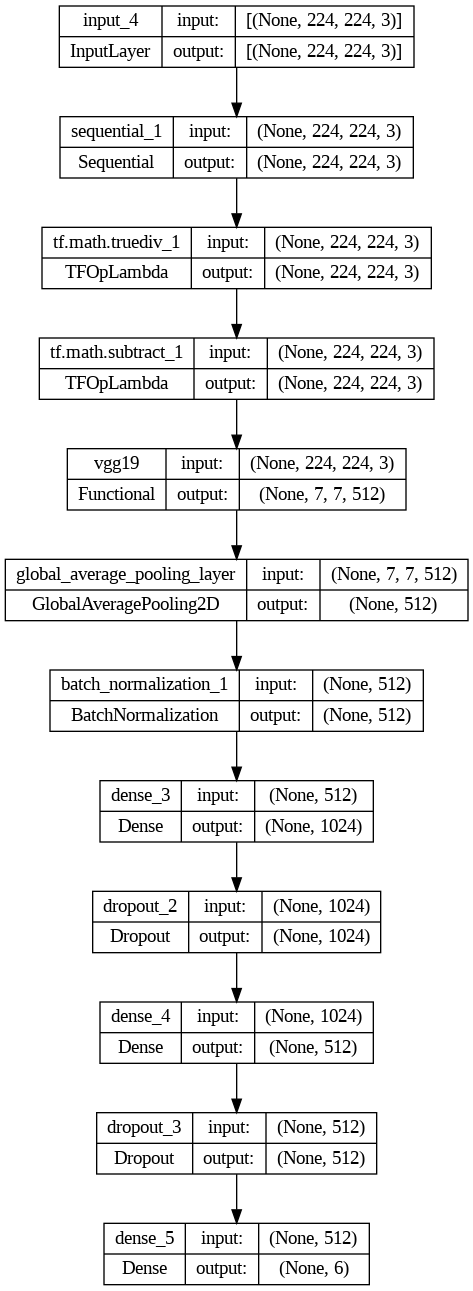

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_learning_rate=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')]
              )

In [ ]:
print(outputs.shape)

(None, 6)


In [ ]:
initial_epochs=10
loss0, accuracy0 = model.evaluate(test_data)

14/14 [==============================] - 3s 140ms/step - loss: 15.6951 - categorical_accuracy: 0.0000e+00


In [ ]:
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

initial loss: 15.70
initial accuracy: 0.00


In [ ]:
history=model.fit(train_data,
                  epochs=initial_epochs,
                  validation_data=test_data)

Epoch 1/80
63/63 [==============================] - 13s 196ms/step - loss: 9.4710 - categorical_accuracy: 0.1614 - val_loss: 9.0214 - val_categorical_accuracy: 0.1820
Epoch 2/80
63/63 [==============================] - 13s 202ms/step - loss: 9.0637 - categorical_accuracy: 0.1554 - val_loss: 8.6180 - val_categorical_accuracy: 0.1513
Epoch 3/80
63/63 [==============================] - 14s 206ms/step - loss: 8.6288 - categorical_accuracy: 0.1509 - val_loss: 8.2386 - val_categorical_accuracy: 0.1749
Epoch 4/80
63/63 [==============================] - 13s 203ms/step - loss: 8.2081 - categorical_accuracy: 0.1574 - val_loss: 7.8235 - val_categorical_accuracy: 0.1678
Epoch 5/80
63/63 [==============================] - 13s 207ms/step - loss: 7.8444 - categorical_accuracy: 0.1504 - val_loss: 7.4635 - val_categorical_accuracy: 0.1962
Epoch 6/80
63/63 [==============================] - 13s 204ms/step - loss: 7.4639 - categorical_accuracy: 0.1564 - val_loss: 7.1154 - val_categorical_accuracy: 0.179